# Render Contours

author = Caroline Magg <br>
date = 01 April 2020 <br>
test PatientData class and different segmentation algorithms <br>
___________________________________
history: <br>
2020-04-12 <br>
build PatientData wrapper with convient methods for data processing <br>
2020-04-15 <br>
refactor PatientData to have object for PatientData (contour, pre and post treatment) and DicomFileWrapper <br>
first tests with active contour methods form skikit-image <br>
2020-04-16 <br>
refactor 2D slices functions <br>
2020-04-20 <br>
code clean up and correct mapping <br>
2020-04-22,28,29 <br>
test segmentation methods for struct='Brain' <br>
2020-05-04 <br>
test segmentation for struct='Corpus callosum' <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted
import scipy
import time
import logging as log

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
#from utils_explore import read_structure,read_contour,read_contour_names,read_contour_row
from PatientData import PatientData
from DicomWrapper import DicomWrapper

In [5]:
# add path to data here
path_data = "../../Data/" 

### Explore folder structure and naming

In [6]:
idx = 2
folder_name = os.path.join(path_data, str(idx))
folder = os.listdir(folder_name)
folder

['2',
 'BRAVO 4-19-17',
 'BRAVOPOST 4-19-17',
 'CT',
 'RD.Jacks2IMPT.dcm',
 'RD.Jacks2IMPTb.dcm',
 'RS.Jacks2.dcm',
 'T1 3-14-17',
 'T1 3-19-17',
 'T1POST 3-13-17']

In [7]:
contours_list = pd.read_csv("list_contours.csv",delimiter=';')
contours_list

,Number,RoiName
0,1,Brain
1,2,Cerebel
2,3,Cingulum
3,4,Corpus callosum
4,5,CTV
5,6,Entorhinal
6,7,Fornix
7,8,FrontalLobe
8,9,GTV
9,10,Hippocampus


In [8]:
contour_of_interest = ["PTV","GTV","CTV"]

# PatientData

In [9]:
files = os.listdir(os.path.join(path_data, str(idx)))
path_contour = os.path.join(path_data, str(idx), 'RS.Jacks1.dcm')
path_preop = os.path.join(path_data, str(idx), 'CT')
path_postop1 = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x]]
dcm = pydicom.dcmread(path_contour)
path_contour, path_preop, path_postop1

('../../Data/1\\RS.Jacks1.dcm',
 '../../Data/1\\CT',
 ['../../Data/1\\T1 +C 3-15-16',
  '../../Data/1\\T1 +C 3-23-16',
  '../../Data/1\\T1 +C 4-29-16'])

In [10]:
data = PatientData(path_preop, path_postop1, path_contour)

INFO:
Preop dicom
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-15-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-23-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 4-29-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel sp

In [11]:
data.get_all_contour_names()

array(['Amydgala left', 'Amydgala right', 'Ant Thalamus L',
       'Ant Thalamus R', 'Body', 'Brain', 'BrainInfratent',
       'BrainSupraTent', 'Brainstem', 'BrainstemCore', 'BrainstemSurf',
       'C1A', 'CG L', 'CG R', 'CTV', 'Cerebel ANT YL', 'Cerebell POST YL',
       'Cerebellum Jacks', 'CerebellumAnt LT', 'Cingulum left',
       'Cingulum right', 'CochleaLt', 'CochleaRt', 'Corpus callosum',
       'Dentate nucleus', 'Dose 102.8[%]', 'Dose 103.7[%]', 'Dose 104[%]',
       'Dose 95[%]', 'Entorhinal cor.L', 'Entorhinal cor.R',
       'ExtraThalamic L', 'ExtraThalamic R', 'FS', 'Fornix',
       'FrontalLobe_L', 'FrontalLobe_R2', 'GTV', 'HP', 'HippoHeadLt',
       'HippoHeadRt', 'HippoTailLt', 'HippoTailRt', 'HippocampusLt',
       'HippocampusRt', 'Hypothalamus', 'LFWM', 'LIP', 'LM', 'LSW',
       'LacrimalLt', 'LacrimalRt', 'LensLt', 'LensRt', 'Mam. bodies',
       'Mam.thal.tract L', 'Mam.thal.tract R', 'MastoidLt', 'MastoidRt',
       'Medulla C1', 'Medulla C2C3', 'NPX', 'NonTarg

In [12]:
struct = ["Brain","PTV1","PTV2","GTV","CTV","Scalp","Corpus callosum"]
data.read_filtered_contour(roiname=struct,mode="exact")

INFO:Start filtering contour list for RoiNames ['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'] with mode exact
INFO:Reading contour information of RoiName Brain
INFO:Reading contour information of RoiName PTV1
INFO:Reading contour information of RoiName PTV2
INFO:Reading contour information of RoiName GTV
INFO:Reading contour information of RoiName CTV
INFO:Reading contour information of RoiName Scalp
INFO:Reading contour information of RoiName Corpus callosum


In [13]:
data.get_filtered_contour_names()

1               Brain
30               PTV1
31               PTV2
9                 GTV
8                 CTV
34              Scalp
54    Corpus callosum
Name: RoiName, dtype: object

In [14]:
found = data.get_filtered_contour_names().values
index = data.contour_list_names_filtered['first'].values
found, index

(array(['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'],
       dtype=object),
 array([28, 119, 121, 124, 122, 15, 72], dtype=object))

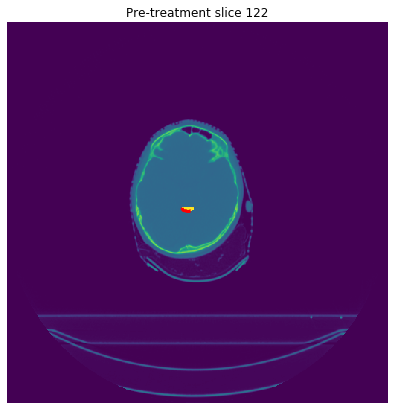

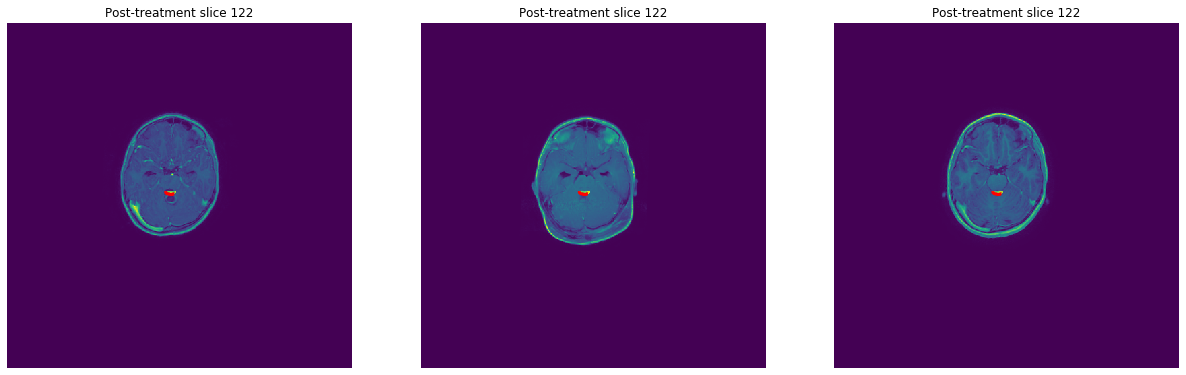

In [15]:
# visualise single segmentation in 2D in all dicom files
data.show_overlays_init("CTV", 122)

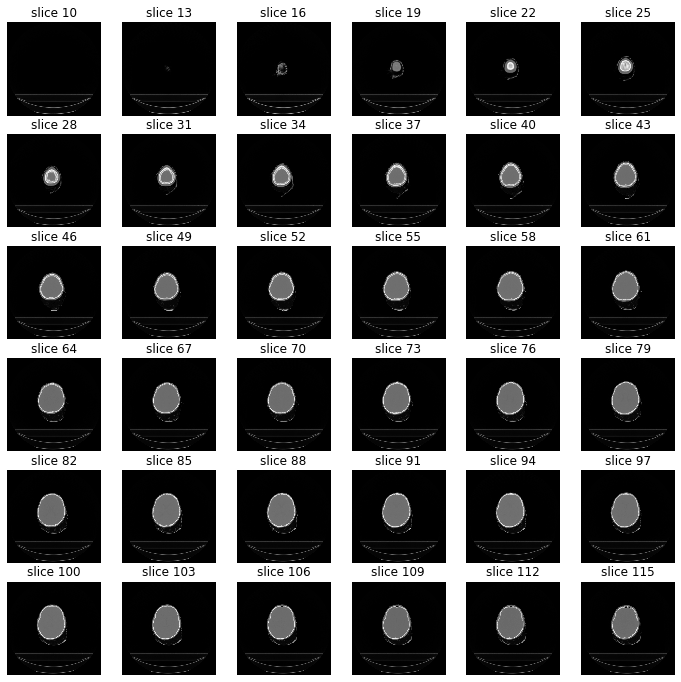

In [16]:
# visualize slices of pre op
data.show_slices2D(data.get_pre_images())

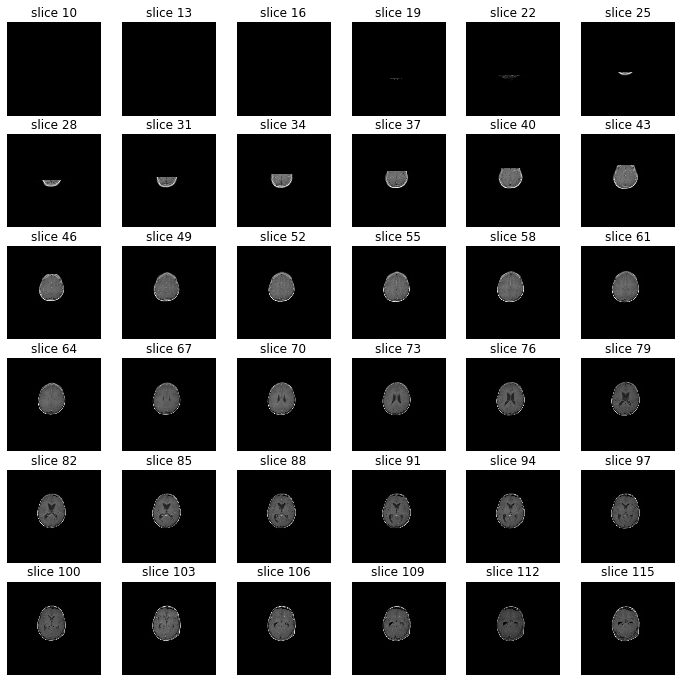

In [17]:
#visualize slices of post op
data.show_slices2D(data.get_post_images()[1])

Corpus callosum


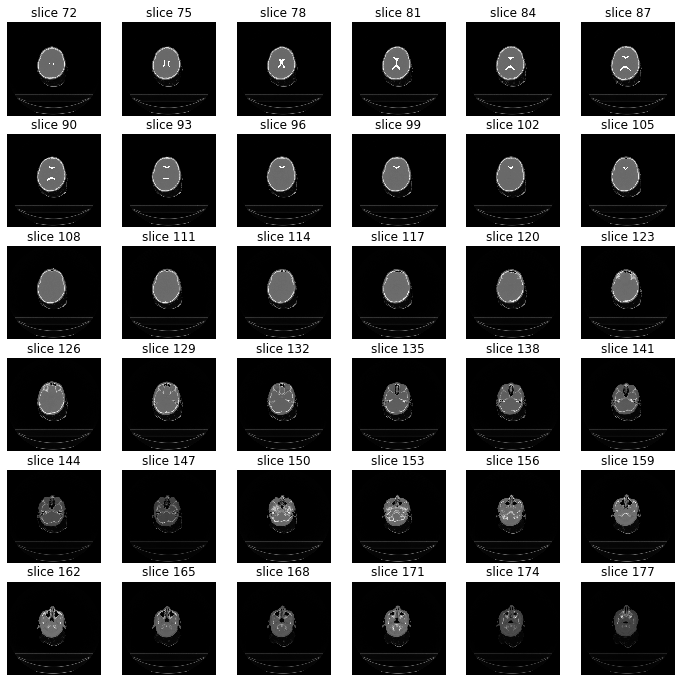

In [18]:
# visualize slices of pre op with contours
ind = 6
print(found[ind])
data.show_slices2D_contour(found[ind], show_every=3, start_with=index[ind])

# Segmentation Draft

In [19]:
import skimage.segmentation as segmentation

In [20]:
import skimage
skimage.__version__

'0.16.2'

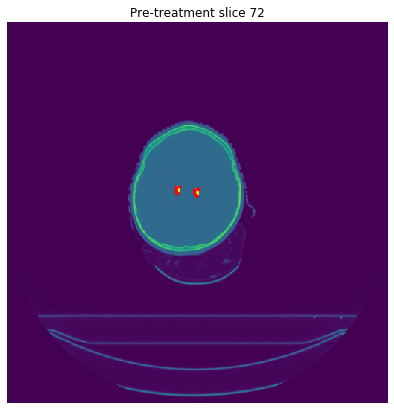

In [32]:
# init structure to process
ind = 72
struct = "Corpus callosum"
img_postop = data.get_post_images(ind)
img_preop = data.get_pre_images(ind)[0]
pts_init = data.get_contour_points(struct, ind)[0]
contour_init = data.get_contour_overlay(struct, ind)[0]

plt.show()
data.show_overlay2D_pre(struct,ind)

In [33]:
img_postop[0].dtype, img_preop.dtype, contour_init.dtype

(dtype('uint16'), dtype('uint16'), dtype('uint16'))

In [57]:
def plot_segmentation(img, pts_init=None, pts_dilated=None, pts_process=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap=plt.cm.gray)
    if pts_init is not None:
        print(len(pts_init))
        for pts in pts_init:
            ax.plot(pts[:, 0], pts[:, 1], '--r', lw=2, label='init')
    if pts_dilated is not None:        
        print(len(pts_init))
        for pts in pts_dilated:
            ax.plot(pts[:, 0], pts[:, 1], '-g', lw=2, label='dilated')
    if pts_process is not None:        
        print(len(pts_init))
        for pts in pts_process:
            ax.plot(pts[:, 0], pts[:, 1], '-b', lw=3, label='processed')
    ax.legend()
    plt.show()

In [64]:
def contour_to_pts(contour):
    tmp = cv2.findContours(contour.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    pts = []
    for t in tmp:
        tmp2 = t.reshape(t.shape[0], t.shape[2])
        pts.append(tmp2)
    return pts

In [72]:
def dilate_segmentation(contour_mask_init, kernel_size=(10,10), iteration=1, debug=False, image = None):
    kernel = np.ones(kernel_size, np.uint8)
    contour_dilated = cv2.dilate(contour_mask_init, kernel, iterations = iteration)
    pts_dilated = contour_to_pts(contour_dilated)
    pts_init = contour_to_pts(contour_mask_init)
    if debug:
        toshow = contour_mask_init + contour_dilated
        plt.imshow(toshow)
        plt.show()
        if image is not None:
            plot_segmentation(image, pts_init, pts_dilated)
    return pts_dilated

In [73]:
def create_contour(img, pts):
    contour_img = np.zeros_like(img, dtype=np.int16)
    vertices = pts.astype(np.int32)
    if len(vertices) != 0:
        cv2.drawContours(contour_img, [vertices], -1, (255,0,0), -1)
    return contour_img

In [74]:
def image_preprocessing(image):
    img = image.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

In [94]:
def segmentations_active_contour(stack_img, stack_contour, stack_pts):
    contour_proc = []
    pts_proc = []
    pts_dilated2 = []
    for idx in range(len(stack_img)):        
        t = time.time()
        image = stack_img[idx]
        contour_init = stack_contour[idx]
        pts_init = stack_pts[idx]
        if pts_init is not None: 
            pts_dilated = dilate_segmentation(contour_init,kernel_size=(10,10),debug=False)
            pts_proc2 = []
            contour_proc2 = []
            for pts_instance in pts_dilated:
                pts = segmentation.active_contour(image, pts_instance,w_edge=150,beta=2)
                pts_proc2.append(pts)
                contour_proc2.append(create_contour(image, pts))
            contour_proc.append(contour_proc2)
            pts_proc.append(pts_proc2)
            pts_dilated2.append(pts_dilated)
        else:
            contour_proc.append(contour_init)
            pts_proc.append(pts_init)
        elapsed = time.time() - t
        print(' ...', idx, elapsed)
    return pts_proc, contour_proc, pts_dilated2

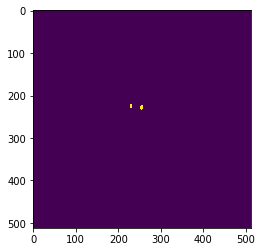

In [95]:
contour_init = data.get_contour_overlay(struct)[72]
plt.imshow(contour_init)

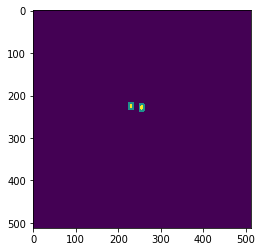

2
2


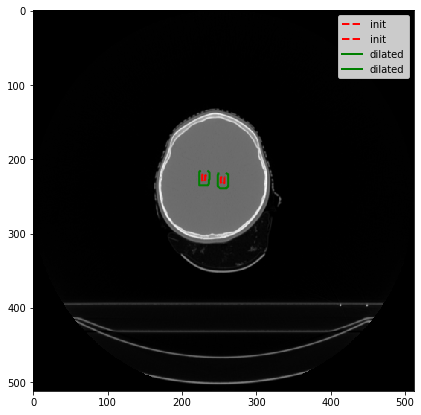

In [96]:
pts_dilated = dilate_segmentation(contour_init, debug=True, image=data.get_pre_images()[72])

In [97]:
# apply contour segmentation to stack of images
first = 72
last = 72+5
img_postop = data.get_post_images()[0]
pts_init = data.get_contour_points(struct)
contour_init = data.get_contour_overlay(struct)
pts_proc, contour_proc, pts_dilated = segmentations_active_contour(img_postop[first:last], contour_init[first:last], pts_init[first:last])

C:\Users\Caroline\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  from ipykernel import kernelapp as app


 ... 0 0.47481775283813477
 ... 1 0.36826014518737793
 ... 2 0.44231414794921875
 ... 3 0.6304481029510498
 ... 4 1.174834966659546


In [98]:
np.shape(contour_proc), np.shape(pts_dilated)

((5,), (5,))

2
2
2


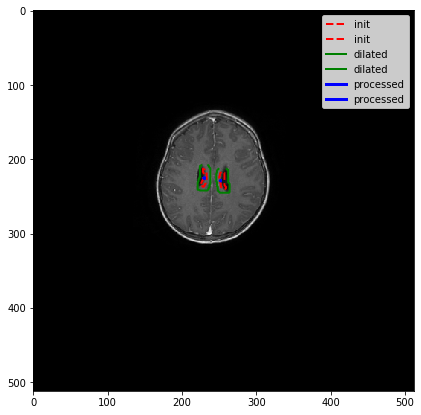

In [99]:
ind = 2
plot_segmentation(img_postop[first+ind], pts_init[first+ind], pts_dilated[ind], pts_proc[ind])

### Test different segmentation methods

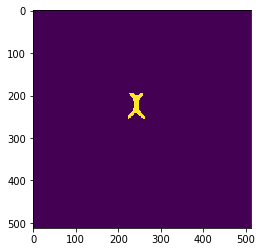

In [104]:
contour_init = data.get_contour_overlay(struct)[80]
plt.imshow(contour_init)

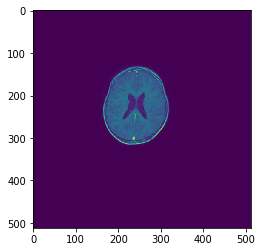

In [111]:
img_postop = data.get_post_images()[0]
image = img_postop[80]
pts_init = data.get_contour_points(struct,80)[0]
plt.imshow(image)

C:\Users\Caroline\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  This is separate from the ipykernel package so we can avoid doing imports until


1
1
1


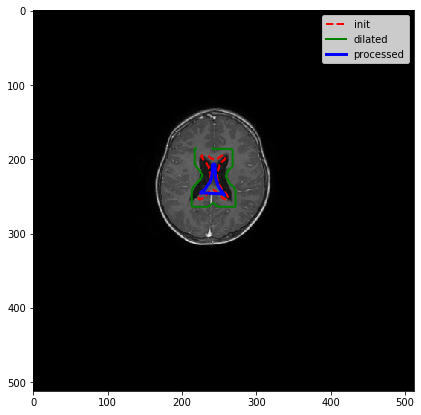

In [112]:
pts_dilated = dilate_segmentation(contour_init,kernel_size=(20,20),debug=False)[0]
#image = image_preprocessing(image)
pts_proc = segmentation.active_contour(image, pts_init[0],w_edge=150,beta=2)
contour_proc = create_contour(image, pts_proc)
plot_segmentation(image, pts_init, [pts_dilated], [pts_proc])

1
1
1


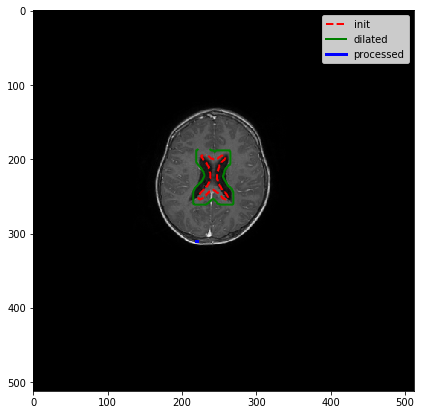

In [114]:
# Chan Vese
# Active contour model by evolving a level set. Can be used to segment objects without clearly defined boundaries.
#image = img_postop[1]
pts_dilated = dilate_segmentation(contour_init,kernel_size=(15,15),debug=False)[0]
contour_dilated = create_contour(image, pts_dilated).astype(np.int8)
#image = image_preprocessing(image)
contour_proc = ~segmentation.chan_vese(image, init_level_set=contour_dilated, lambda1=0.5, lambda2=1.5, mu=0.1)
tmp = cv2.findContours(contour_proc.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1][0]
pts_proc = tmp.reshape((tmp.shape[0], tmp.shape[2]))
#contour_proc = create_contour(image, pts_proc)
plot_segmentation(image, pts_init, [pts_dilated], [pts_proc])

In [115]:
# Morphological Geodesic Active Contours (MorphGAC).
# Geodesic active contours implemented with morphological operators. 
# It can be used to segment objects with visible but noisy, cluttered, broken borders.
#image = img_postop[1]
pts_dilated = dilate_segmentation(contour_init,kernel_size=(15,15),debug=False)[0]
contour_dilated = create_contour(image, pts_dilated).astype(np.int8)
image = skimage.img_as_float(image)
gimage = segmentation.inverse_gaussian_gradient(image)
contour_proc = segmentation.morphological_geodesic_active_contour(gimage, iterations=150,init_level_set=contour_dilated)

In [116]:
np.min(contour_proc), np.max(contour_proc)

(0, 0)

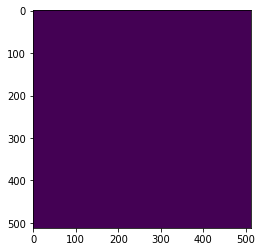

In [117]:
plt.imshow(contour_proc)

In [118]:
# Morphological Active Contours without Edges (MorphACWE)
# Active contours without edges implemented with morphological operators. 
# It can be used to segment objects in images and volumes without well defined borders. 
# It is required that the inside of the object looks different on average than the outside
#image = img_postop[1]
pts_dilated = dilate_segmentation(contour_init,kernel_size=(15,15),debug=False)[0]
contour_dilated = create_contour(image, pts_dilated).astype(np.int8)
image = skimage.img_as_float(image)
contour_proc = segmentation.morphological_chan_vese(image, iterations=35,init_level_set='circle', smoothing=3)

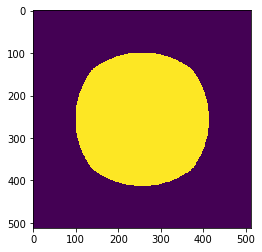

In [119]:
plt.imshow(contour_proc)